In [2]:
%pip install pandas_datareader
%pip install arch


[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
## Importation des packages
import numpy as np
from scipy.stats import norm, truncnorm
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from arch import arch_model
from sklearn.linear_model import LinearRegression
import pandas_datareader as pdr
import numpy as np
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import Lasso



# Projet Monte-Carlo : Jérémie Darracq / Anton Conrad / Emy Olivieri

# Question 1 

### ETAPE 1 : Construction la méthode MCMC : algorithme Métropolis-Hastings à marche aléatoire 

In [4]:
# Fonction de simulation du modèle GARCH(1,1)
def simulate_garch(n, omega, alpha, beta):
    # Initialisation des séries de rendements et de volatilité
    returns = np.zeros(n)
    ecart_type = np.zeros(n)
    ecart_type[0] = np.sqrt(omega / (1 - alpha - beta))
    returns[0] = np.random.normal(0,ecart_type[0])
    # Simulation des rendements et de la volatilité
    for i in range(1, n):
        ecart_type[i] = np.sqrt(omega + alpha * returns[i-1]**2 + beta * ecart_type[i-1]**2)
        returns[i] = np.random.normal(0, ecart_type[i])
    
    # Retourne les rendements et les volatilités simulés
    return returns, ecart_type

In [5]:
# Fonction de densité à priori tronquée ( nos paramètres ne peuvent pas être négatifs)
def prior_density(x, mu, ecart_type,lower=0,upper=np.inf): 
    return truncnorm.pdf(x, (lower - mu) / ecart_type, (upper - mu) / ecart_type, mu, ecart_type)

# Fonction de densité à posteriori du modèle GARCH(1,1)
def posterior_density(returns, omega, alpha, beta, mu_omega,mu_alpha,mu_beta, ecart_type_omega, ecart_type_alpha,ecart_type_beta):
    # Calcul de l'écart-type conditionnel
    n = len(returns)
    variances = np.zeros(n)
    variances[0] = np.var(returns)
    for i in range(1, n):
        variances[i] = omega + alpha * returns[i-1]**2 + beta * variances[i-1]
    ecart_type = np.sqrt(variances)
    log_likelihood = np.sum(norm.logpdf(returns, 0, ecart_type))
    log_prior = np.log(prior_density(omega,mu_omega, ecart_type_omega)) \
                + np.log(prior_density(alpha, mu_alpha, ecart_type_alpha)) \
                + np.log(prior_density(beta, mu_beta, ecart_type_beta))
    log_posterior = log_likelihood + log_prior
    return log_posterior

In [6]:
# Algorithme de Metropolis-Hastings à marche aléatoire
def metropolis_hastings(returns,n_iterations, initial_values, proposal_sd, mu_omega,mu_alpha,mu_beta, ecart_type_omega,ecart_type_alpha,ecart_type_beta):
    # Initialisation des paramètres et de la densité à posteriori
    omega, alpha, beta = initial_values
    posterior = posterior_density(returns, omega, alpha, beta, mu_omega ,mu_alpha,mu_beta, ecart_type_omega,ecart_type_alpha,ecart_type_beta)
    
    # Initialisation des tableaux pour stocker les paramètres acceptés
    accepted_omega = np.zeros(n_iterations)
    accepted_alpha = np.zeros(n_iterations)
    accepted_beta = np.zeros(n_iterations)
    
    # Initialisation du compteur d'acceptations
    acceptance_count = 0


    # Boucle d'itérations
    for i in range(n_iterations):
        # Proposition d'un nouveau paramètre
        new_omega = omega + np.random.normal(0, proposal_sd[0])
        new_alpha = alpha + np.random.normal(0, proposal_sd[1])
        new_beta = beta + np.random.normal(0, proposal_sd[2])
        
        # Calcul de la densité à posteriori pour le nouveau paramètre
        new_posterior = posterior_density(returns,new_omega, new_alpha, new_beta, mu_omega,mu_alpha,mu_beta, ecart_type_omega,ecart_type_alpha,ecart_type_beta)   

        # Acceptation ou rejet du nouveau paramètre
        if  0 < new_posterior - posterior:
            omega, alpha, beta = new_omega, new_alpha, new_beta
            posterior = new_posterior
            accepted_omega[i] = omega
            accepted_alpha[i] = alpha
            accepted_beta[i] = beta
            acceptance_count += 1
        else:   
            u = np.random.uniform()
            if np.log(u) < new_posterior - posterior : 
                omega, alpha, beta = new_omega, new_alpha, new_beta
                posterior = new_posterior
                accepted_omega[i]=omega
                accepted_alpha[i]= alpha    
                accepted_beta[i]= beta
            else : 
                accepted_omega[i]=omega
                accepted_alpha[i]= alpha    
                accepted_beta[i]= beta
                
                
          # Calcul du taux d'acceptation
    acceptance_rate = acceptance_count / n_iterations

    # Retourne les paramètres acceptés et la densité à posteriori maximale
    return accepted_omega, accepted_alpha, accepted_beta, posterior,acceptance_rate


### Étape 2 : Construction de la méthode ZVMCMC avec variables de contrôle obtenu par régression simple

In [7]:
def _post(omega, alpha, beta):
    return posterior_density(returns, omega, alpha, beta, mu_omega,mu_alpha,mu_beta, ecart_type_omega, ecart_type_alpha,ecart_type_beta)

def partial_derivatives(f, x, y, z, h=1e-6):
    dx = (f(x + h, y, z) - f(x - h, y, z)) / (2*h)
    dy = (f(x, y + h, z) - f(x, y - h, z)) / (2*h)
    dz = (f(x, y, z + h) - f(x, y, z - h)) / (2*h)
    return dx, dy, dz

def grad_(f, x , y,z):
    dx, dy, dz = partial_derivatives(f, x, y, z)
    return(np.array([dx,dy,dz]))

In [8]:
def z_construct(omega_MCMC,alpha_MCMC,beta_MCMC):
    z = []
    for i in range(len(omega_MCMC)):
        omega, alpha, beta = omega_MCMC[i], alpha_MCMC[i], beta_MCMC[i]
        z.append((0.5)*grad_(_post, omega, alpha, beta))
    z = np.asarray(z)
    return z


In [9]:
def w_construct(omega_MCMC,alpha_MCMC,beta_MCMC):
    w = []
    for i in range(len(omega_MCMC)):
        w.append((omega_MCMC[i], alpha_MCMC[i], beta_MCMC[i]))
    w = np.asarray(w)
    return w 
    

In [10]:
def a_construct(w,z):
    r = LinearRegression()
    a = r.fit(z, w).coef_
    return a 

In [11]:
def ZVMCMC(omega_MCMC,alpha_MCMC,beta_MCMC):
    omega_ZVMCMC = []
    alpha_ZVMCMC = []
    beta_ZVMCMC = []
    for i in range(len(omega_MCMC)):
        z = (-0.5)*grad_(_post, omega_MCMC[i], alpha_MCMC[i], beta_MCMC[i])
        trans = np.dot(a,z)
        om = omega_MCMC[i] + trans[0]
        al = alpha_MCMC[i] + trans[1]
        be = beta_MCMC[i] + trans[2]
        omega_ZVMCMC.append(om)
        alpha_ZVMCMC.append(al)
        beta_ZVMCMC.append(be)
    omega_ZVMCMC = np.asarray(omega_ZVMCMC)
    alpha_ZVMCMC = np.asarray(alpha_ZVMCMC)
    beta_ZVMCMC = np.asarray(beta_ZVMCMC)
    return omega_ZVMCMC,alpha_ZVMCMC,beta_ZVMCMC

### Etape 2 : Application aux données simulées

In [12]:
# Paramètres du modèle GARCH(1,1) 
omega = 0.1
alpha = 0.2
beta = 0.7

# Simulation du modèle GARCH(1,1) pour 500 périodes
n= 1000 ## Nombre de données
n_iterations = 20000  ## Nombres d'itérations de l'Algorithme 


## Paramètres de variances de nos lois de propositions et de nos lois à prioris
proposal_sd = [0.05,0.05,0.05]
mu_omega = 0
mu_alpha = 0.15
mu_beta = 0.6
ecart_type_omega = 50 ## ecart_type = np.sqrt(variance)
ecart_type_alpha = 50
ecart_type_beta = 50

## Définit les valeurs arbitraires de départs
initial_values = [0.05,0.1,0.6]
returns = simulate_garch(n, omega, alpha, beta)[0]

In [13]:
## Calcul des estimateurs MCMC

omega_MCMC, alpha_MCMC, beta_MCMC, posterior_max , acceptance_rate= metropolis_hastings(returns, n_iterations, initial_values, proposal_sd, mu_omega,mu_alpha,mu_beta, ecart_type_omega,ecart_type_alpha,ecart_type_beta)

omega_MCMC = omega_MCMC[2000:]
alpha_MCMC = alpha_MCMC[2000:]
beta_MCMC = beta_MCMC[2000:]

/var/folders/l0/5qk3mw253y945myr_1tfc8z00000gn/T/ipykernel_5799/2849481548.py:15: RuntimeWarning: divide by zero encountered in log
  log_prior = np.log(prior_density(omega,mu_omega, ecart_type_omega)) \
/var/folders/l0/5qk3mw253y945myr_1tfc8z00000gn/T/ipykernel_5799/2849481548.py:13: RuntimeWarning: invalid value encountered in sqrt
  ecart_type = np.sqrt(variances)
/var/folders/l0/5qk3mw253y945myr_1tfc8z00000gn/T/ipykernel_5799/2849481548.py:16: RuntimeWarning: divide by zero encountered in log
  + np.log(prior_density(alpha, mu_alpha, ecart_type_alpha)) \


In [14]:
## Calcul des estimateurs ZVMCMC
w = w_construct(omega_MCMC,alpha_MCMC,beta_MCMC)
z = z_construct(omega_MCMC,alpha_MCMC,beta_MCMC)
a = a_construct(w,z)

omega_ZVMCMC,alpha_ZVMCMC,beta_ZVMCMC = ZVMCMC(omega_MCMC,alpha_MCMC,beta_MCMC)

In [15]:
## Estimateurs Bayésiens MCMC et ZVMCMC
omega_bay_MCMC = omega_MCMC.mean()
alpha_bay_MCMC = alpha_MCMC.mean()
beta_bay_MCMC = beta_MCMC.mean()
omega_bay_ZVMCMC = omega_ZVMCMC.mean()
alpha_bay_ZVMCMC = alpha_ZVMCMC.mean()
beta_bay_ZVMCMC = beta_ZVMCMC.mean()


Valeur de l'estimateur bayésien MCMC de omega :  0.1241349942646834
Valeur de l'estimateur bayésien ZVMCMC de omega :  0.12512632628044146
Erreur quadratique moyenne de l'estimateur omega MCMC : 0.0005824979481563003
Erreur quadratique moyenne de l'estimateur omega ZVMCM : 0.0006313322723512028
la variance de l'estimateur MCMC de omega est de :  0.0007265358253076457
la variance de l'estimateur ZVMCMC de omega est de :  0.00013228992230294905
Intervalle de confiance de confiance de omega MCMC à 95%  : 0.12374121908725189 0.12452876944211491
Intervalle de confiance de confiance de omega ZVMCMC à 95%  : 0.12495829768407911 0.1252943548768038


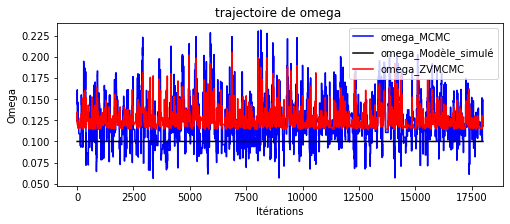

In [46]:
## Comparaison des estimateurs MCMC et ZVMCMC pour omega 

omega_true = [omega for i in range (len(omega_MCMC))]
plt.figure(figsize=(8,3))
plt.plot(omega_MCMC, color="blue",label="omega_MCMC")
plt.plot(omega_true,color="black",label="omega_Modèle_simulé")
plt.plot(omega_ZVMCMC,color= "red",label="omega_ZVMCMC")
plt.title("trajectoire de omega ")
plt.ylabel("Omega")
plt.xlabel("Itérations")
plt.legend()

mse_omega_MCMC = np.mean((omega_bay_MCMC - omega)**2)
mse_omega_ZVMCMC = np.mean((omega_bay_ZVMCMC - omega)**2)

mean_omega_MCMC = np.mean(omega_MCMC)
std_omega_MCMC = np.std(omega_MCMC)
lower_omega_MCMC = mean_omega_MCMC - 1.96* std_omega_MCMC/np.sqrt(len(omega_MCMC))
upper_omega_MCMC = mean_omega_MCMC + 1.96* std_omega_MCMC/np.sqrt(len(omega_MCMC))

mean_omega_ZVMCMC = np.mean(omega_ZVMCMC)
std_omega_ZVMCMC = np.std(omega_ZVMCMC)
lower_omega_ZVMCMC = mean_omega_ZVMCMC - 1.96* std_omega_ZVMCMC/np.sqrt(len(omega_ZVMCMC))
upper_omega_ZVMCMC = mean_omega_ZVMCMC + 1.96* std_omega_ZVMCMC/np.sqrt(len(omega_ZVMCMC))


print("Valeur de l'estimateur bayésien MCMC de omega : ", omega_bay_MCMC)
print("Valeur de l'estimateur bayésien ZVMCMC de omega : ", omega_bay_ZVMCMC)
print("Erreur quadratique moyenne de l'estimateur omega MCMC :", mse_omega_MCMC)
print("Erreur quadratique moyenne de l'estimateur omega ZVMCM :", mse_omega_ZVMCMC)
print("la variance de l'estimateur MCMC de omega est de : ",np.var(omega_MCMC))
print("la variance de l'estimateur ZVMCMC de omega est de : ",np.var(omega_ZVMCMC))
print("Intervalle de confiance de confiance de omega MCMC à 95%  :",lower_omega_MCMC,upper_omega_MCMC)
print("Intervalle de confiance de confiance de omega ZVMCMC à 95%  :",lower_omega_ZVMCMC,upper_omega_ZVMCMC)





Valeur de l'estimateur bayésien MCMC de alpha :  0.21936898801962187
Valeur de l'estimateur bayésien ZVMCMC de alpha :  0.2204269068934793
Erreur quadratique moyenne de l'estimateur alpha MCMC : 0.00037515769690425526
Erreur quadratique moyenne de l'estimateur alpha ZVMCM : 0.00041725852523487154
la variance de l'estimateur MCMC de alpha est de :  0.001144516513614212
la variance de l'estimateur ZVMCMC de alpha est de :  0.00013075323642639818
Intervalle de confiance de confiance de alpha MCMC 95% : 0.21887475603188172 0.21986322000736203
Intervalle de confiance de confiance de alpha ZVMCMC à 95% : 0.22025985706174975 0.22059395672520885


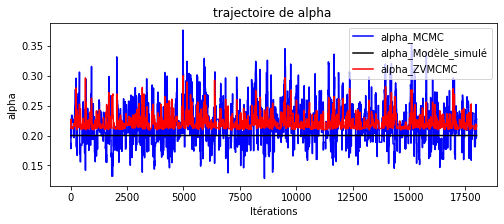

In [47]:
## Comparaison des estimateurs MCMC et ZVMCMC pour alpha 

alpha_true = [alpha for i in range (len(alpha_MCMC))]
plt.figure(figsize=(8,3))
plt.plot(alpha_MCMC, color="blue",label="alpha_MCMC")
plt.plot(alpha_true,color="black",label="alpha_Modèle_simulé")
plt.plot(alpha_ZVMCMC,color= "red",label="alpha_ZVMCMC")
plt.title("trajectoire de alpha ")
plt.xlabel("Itérations")
plt.ylabel("alpha")
plt.legend()

mse_alpha_MCMC = np.mean((alpha_bay_MCMC - alpha)**2)
mse_alpha_ZVMCMC = np.mean((alpha_bay_ZVMCMC -alpha)**2)
mean = np.mean(alpha_MCMC)
std = np.std(alpha_MCMC)
lower_alpha_MCMC = mean - 1.96* std/np.sqrt(len(alpha_MCMC))
upper_alpha_MCMC = mean + 1.96* std/np.sqrt(len(alpha_MCMC))

mean_alpha_ZVMCMC = np.mean(alpha_ZVMCMC)
std_alpha_ZVMCMC = np.std(alpha_ZVMCMC)
lower_alpha_ZVMCMC = mean_alpha_ZVMCMC - 1.96* std_alpha_ZVMCMC/np.sqrt(len(alpha_ZVMCMC))
upper_alpha_ZVMCMC = mean_alpha_ZVMCMC + 1.96* std_alpha_ZVMCMC/np.sqrt(len(alpha_ZVMCMC))


print("Valeur de l'estimateur bayésien MCMC de alpha : ", alpha_bay_MCMC)
print("Valeur de l'estimateur bayésien ZVMCMC de alpha : ", alpha_bay_ZVMCMC)
print("Erreur quadratique moyenne de l'estimateur alpha MCMC :", mse_alpha_MCMC)
print("Erreur quadratique moyenne de l'estimateur alpha ZVMCM :", mse_alpha_ZVMCMC)
print("la variance de l'estimateur MCMC de alpha est de : ",np.var(alpha_MCMC))
print("la variance de l'estimateur ZVMCMC de alpha est de : ",np.var(alpha_ZVMCMC))
print("Intervalle de confiance de confiance de alpha MCMC 95% :",lower_alpha_MCMC,upper_alpha_MCMC)
print("Intervalle de confiance de confiance de alpha ZVMCMC à 95% :",lower_alpha_ZVMCMC,upper_alpha_ZVMCMC)





Valeur de l'estimateur bayésien MCMC de beta :  0.6507642612342669
Valeur de l'estimateur bayésien ZVMCMC de beta :  0.6490555843158794
Erreur quadratique moyenne de l'estimateur beta : 0.002424157971807509
Erreur quadratique moyenne de l'estimateur beta : 0.0025953334893964687
la variance de l'estimateur MCMC de beta est de :  0.0020668180218561126
la variance de l'estimateur ZVMCMC de beta est de :  0.00029216953996670096
Intervalle de confiance de confiance à 95% : 0.6501001039523272 0.6514284185162066
Intervalle de confiance de confiance à 95% : 0.6488058735382078 0.649305295093551


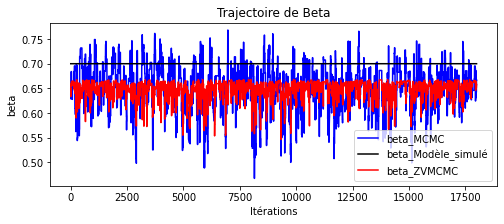

In [48]:
## Comparaison des estimateurs MCMC et ZVMCMC pour omega 
beta_true = [beta for i in range (len(alpha_MCMC))]
plt.figure(figsize=(8,3))
plt.plot(beta_MCMC, color="blue",label="beta_MCMC")
plt.plot(beta_true,color="black",label="beta_Modèle_simulé")
plt.plot(beta_ZVMCMC,color= "red",label="beta_ZVMCMC")
plt.title("Trajectoire de Beta")
plt.xlabel("Itérations")
plt.ylabel("beta")
plt.legend()

mse_beta_MCMC = np.mean((beta_bay_MCMC - beta)**2)
mse_beta_ZVMCMC = np.mean((beta_bay_ZVMCMC - beta)**2)

mean = np.mean(beta_MCMC)
std = np.std(beta_MCMC)

lower_beta_MCMC = mean - 1.96* std/np.sqrt(len(beta_MCMC))
upper_beta_MCMC = mean + 1.96* std/np.sqrt(len(beta_MCMC))

mean_beta_ZVMCMC = np.mean(beta_ZVMCMC)
std_beta_ZVMCMC = np.std(beta_ZVMCMC)
lower_beta_ZVMCMC = mean_beta_ZVMCMC - 1.96* std_beta_ZVMCMC/np.sqrt(len(beta_ZVMCMC))
upper_beta_ZVMCMC = mean_beta_ZVMCMC + 1.96* std_beta_ZVMCMC/np.sqrt(len(beta_ZVMCMC))




print("Valeur de l'estimateur bayésien MCMC de beta : ", beta_bay_MCMC)
print("Valeur de l'estimateur bayésien ZVMCMC de beta : ", beta_bay_ZVMCMC)
print("Erreur quadratique moyenne de l'estimateur beta :", mse_beta_MCMC)
print("Erreur quadratique moyenne de l'estimateur beta :", mse_beta_ZVMCMC)
print("la variance de l'estimateur MCMC de beta est de : ",np.var(beta_MCMC))
print("la variance de l'estimateur ZVMCMC de beta est de : ",np.var(beta_ZVMCMC))
print("Intervalle de confiance de confiance à 95% :",lower_beta_MCMC,upper_beta_MCMC)
print("Intervalle de confiance de confiance à 95% :",lower_beta_ZVMCMC,upper_beta_ZVMCMC)


### Étape 2 : Applications aux données réelles

In [25]:
start_date = "2021-01-01"
end_date = "2022-12-31"

df = pdr.get_data_fred(["DEXUSEU", "DEXUSUK"], start_date, end_date)
df["returns"] = (df["DEXUSUK"] - df["DEXUSUK"].shift(1)) / df["DEXUSUK"].shift(1)
df["log_returns"] = np.log(df["returns"])
df = df.dropna()
returns_real = df["returns"].to_numpy()
returns_real_pourcentage = returns_real * 100
# données sur les rendements de la paire GBP/USD

/Users/aconrad/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/aconrad/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
n_iterations = 20000  
proposal_sd = [0.01,0.01,0.01]
mu_omega = 0
mu_alpha = 0.15
mu_beta = 0.6
ecart_type_omega = 50 ## ecart_type = np.sqrt(variance)
ecart_type_alpha = 50
ecart_type_beta = 50
## Définit les valeurs arbitraires de départs
initial_values = [0.05,0.1,0.6]
returns = returns_real_pourcentage

In [27]:
## Calcul des estimateurs MCMC

omega_MCMC_real, alpha_MCMC_real, beta_MCMC_real, posterior_max , acceptance_rate= metropolis_hastings(returns, n_iterations, initial_values, proposal_sd, mu_omega,mu_alpha,mu_beta, ecart_type_omega,ecart_type_alpha,ecart_type_beta)

omega_MCMC_real = omega_MCMC_real[2000:]
alpha_MCMC_real = alpha_MCMC_real[2000:]
beta_MCMC_real = beta_MCMC_real[2000:]

/var/folders/l0/5qk3mw253y945myr_1tfc8z00000gn/T/ipykernel_5799/2849481548.py:15: RuntimeWarning: divide by zero encountered in log
  log_prior = np.log(prior_density(omega,mu_omega, ecart_type_omega)) \
/var/folders/l0/5qk3mw253y945myr_1tfc8z00000gn/T/ipykernel_5799/2849481548.py:13: RuntimeWarning: invalid value encountered in sqrt
  ecart_type = np.sqrt(variances)


In [28]:
## Calcul des estimateurs ZVMCMC
w = w_construct(omega_MCMC_real,alpha_MCMC_real,beta_MCMC_real)
z = z_construct(omega_MCMC_real,alpha_MCMC_real,beta_MCMC_real)
a = a_construct(w,z)

omega_ZVMCMC_real,alpha_ZVMCMC_real,beta_ZVMCMC_real = ZVMCMC(omega_MCMC_real,alpha_MCMC_real,beta_MCMC_real)

In [29]:
## Estimateurs Bayésiens MCMC et ZVMCMC
omega_bay_MCMC_real = omega_MCMC_real.mean()
alpha_bay_MCMC_real = alpha_MCMC_real.mean()
beta_bay_MCMC_real = beta_MCMC_real.mean()
omega_bay_ZVMCMC_real = omega_ZVMCMC_real.mean()
alpha_bay_ZVMCMC_real = alpha_ZVMCMC_real.mean()
beta_bay_ZVMCMC_real = beta_ZVMCMC_real.mean()

In [30]:
# Calcul des paramètres avec une méthode ad hoc 
model = arch_model(returns_real_pourcentage,mean="Constant",vol='GARCH', p=1, q=1)
results = model.fit()
# Print results
print(results.summary())



Iteration:      1,   Func. Count:      6,   Neg. LLF: 56517.26013541522
Iteration:      2,   Func. Count:     17,   Neg. LLF: 12552.356118955176
Iteration:      3,   Func. Count:     24,   Neg. LLF: 92.79180727500443
Iteration:      4,   Func. Count:     30,   Neg. LLF: 170.44020069640698
Iteration:      5,   Func. Count:     37,   Neg. LLF: 87.56606523911748
Iteration:      6,   Func. Count:     42,   Neg. LLF: 87.35664244955547
Iteration:      7,   Func. Count:     47,   Neg. LLF: 87.27068975479963
Iteration:      8,   Func. Count:     52,   Neg. LLF: 87.2732657567091
Iteration:      9,   Func. Count:     58,   Neg. LLF: 87.24965268875422
Iteration:     10,   Func. Count:     63,   Neg. LLF: 87.24963893874953
Iteration:     11,   Func. Count:     68,   Neg. LLF: 87.24963750270713
Iteration:     12,   Func. Count:     72,   Neg. LLF: 87.24963657185691
Optimization terminated successfully    (Exit mode 0)
            Current function value: 87.24963750270713
            Iterations: 12


Valeur de l'estimateur bayésien MCMC de omega :  0.020420453090921522
Valeur de l'estimateur bayésien ZVMCMC de omega :  0.02098143764952129
la variance de l'estimateur MCMC de omega est de :  0.0001695457587255403
la variance de l'estimateur ZVMCMC de omega est de :  0.00011774638252490712
Intervalle de confiance de confiance de omega real MCMC à 95% : 0.02023022997824707 0.020610676203595975
Intervalle de confiance de confiance de omega real ZVMCMC à 95% : 0.020822914166664354 0.021139961132378225


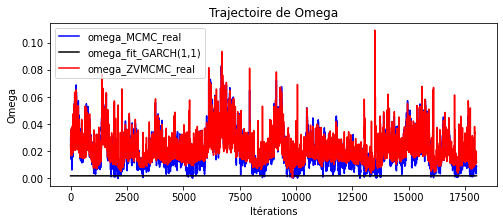

In [50]:
## Comparaison des estimateurs MCMC et ZVMCMC pour omega 

omega_true = [1.9090e-03 for i in range (len(omega_MCMC_real))]
plt.figure(figsize=(8,3))
plt.plot(omega_MCMC_real, color="blue",label="omega_MCMC_real")
plt.plot(omega_true,color="black",label="omega_fit_GARCH(1,1)")
plt.plot(omega_ZVMCMC_real,color= "red",label="omega_ZVMCMC_real")
plt.title("Trajectoire de Omega")
plt.xlabel("Itérations")
plt.ylabel("Omega")
plt.legend()

mean_omega_MCMC_real = np.mean(omega_MCMC_real)
std_omega_MCMC_real= np.std(omega_MCMC_real)
lower_omega_MCMC_real = mean_omega_MCMC_real - 1.96* std_omega_MCMC_real/np.sqrt(len(omega_MCMC_real))
upper_omega_MCMC_real = mean_omega_MCMC_real + 1.96* std_omega_MCMC_real/np.sqrt(len(omega_MCMC_real))

mean_omega_ZVMCMC_real = np.mean(omega_ZVMCMC_real)
std_omega_ZVMCMC_real = np.std(omega_ZVMCMC_real)
lower_omega_ZVMCMC_real = mean_omega_ZVMCMC_real - 1.96* std_omega_ZVMCMC_real/np.sqrt(len(omega_ZVMCMC_real))
upper_omega_ZVMCMC_real = mean_omega_ZVMCMC_real + 1.96* std_omega_ZVMCMC_real/np.sqrt(len(omega_ZVMCMC_real))



print("Valeur de l'estimateur bayésien MCMC de omega : ", omega_bay_MCMC_real)
print("Valeur de l'estimateur bayésien ZVMCMC de omega : ", omega_bay_ZVMCMC_real)
print("la variance de l'estimateur MCMC de omega est de : ",np.var(omega_MCMC_real))
print("la variance de l'estimateur ZVMCMC de omega est de : ",np.var(omega_ZVMCMC_real))
print("Intervalle de confiance de confiance de omega real MCMC à 95% :",lower_omega_MCMC_real,upper_omega_MCMC_real)
print("Intervalle de confiance de confiance de omega real ZVMCMC à 95% :",lower_omega_ZVMCMC_real,upper_omega_ZVMCMC_real)



Valeur de l'estimateur bayésien MCMC de alpha :  0.15108215152511117
Valeur de l'estimateur bayésien ZVMCMC de alpha :  0.15898682773019396
la variance de l'estimateur MCMC de alpha est de :  0.004069494618422121
la variance de l'estimateur ZVMCMC de alpha est de :  0.0023040191322929097
Intervalle de confiance de confiance de alpha real MCMC à 95% : 0.15015020700702814 0.1520140960431942
Intervalle de confiance de confiance de alpha real ZVMCMC à 95% : 0.15828559390096403 0.1596880615594239


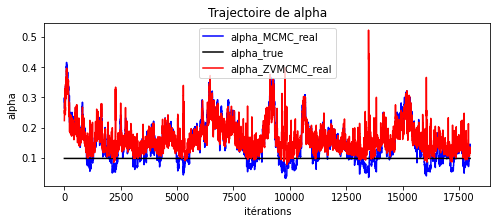

In [52]:
## Comparaison des estimateurs MCMC et ZVMCMC pour omega 

alpha_true = [ 0.0978  for i in range (len(alpha_MCMC_real))]
plt.figure(figsize=(8,3))
plt.plot(alpha_MCMC_real, color="blue",label="alpha_MCMC_real")
plt.plot(alpha_true,color="black",label="alpha_true")
plt.plot(alpha_ZVMCMC_real,color= "red",label="alpha_ZVMCMC_real")
plt.title("Trajectoire de alpha")
plt.xlabel("itérations")
plt.ylabel("alpha")
plt.legend()


mean_alpha_MCMC_real = np.mean(alpha_MCMC_real)
std_alpha_MCMC_real= np.std(alpha_MCMC_real)
lower_alpha_MCMC_real = mean_alpha_MCMC_real - 1.96* std_alpha_MCMC_real/np.sqrt(len(alpha_MCMC_real))
upper_alpha_MCMC_real = mean_alpha_MCMC_real + 1.96* std_alpha_MCMC_real/np.sqrt(len(alpha_MCMC_real))

mean_alpha_ZVMCMC_real = np.mean(alpha_ZVMCMC_real)
std_alpha_ZVMCMC_real = np.std(alpha_ZVMCMC_real)
lower_alpha_ZVMCMC_real = mean_alpha_ZVMCMC_real - 1.96* std_alpha_ZVMCMC_real/np.sqrt(len(alpha_ZVMCMC_real))
upper_alpha_ZVMCMC_real = mean_alpha_ZVMCMC_real + 1.96* std_alpha_ZVMCMC_real/np.sqrt(len(alpha_ZVMCMC_real))



print("Valeur de l'estimateur bayésien MCMC de alpha : ", alpha_bay_MCMC_real)
print("Valeur de l'estimateur bayésien ZVMCMC de alpha : ", alpha_bay_ZVMCMC_real)
print("la variance de l'estimateur MCMC de alpha est de : ",np.var(alpha_MCMC_real))
print("la variance de l'estimateur ZVMCMC de alpha est de : ",np.var(alpha_ZVMCMC_real))
print("Intervalle de confiance de confiance de alpha real MCMC à 95% :",lower_alpha_MCMC_real,upper_alpha_MCMC_real)
print("Intervalle de confiance de confiance de alpha real ZVMCMC à 95% :",lower_alpha_ZVMCMC_real,upper_alpha_ZVMCMC_real)



Valeur de l'estimateur bayésien MCMC de beta :  0.8020349719299612
Valeur de l'estimateur bayésien ZVMCMC de beta :  0.7934618942467132
la variance de l'estimateur MCMC de beta est de :  0.006556308069795511
la variance de l'estimateur ZVMCMC de beta est de :  0.003733361228849307
Intervalle de confiance de confiance de beta real MCMC à 95% : 0.8008520679449188 0.8032178759150036
Intervalle de confiance de confiance de beta real ZVMCMC à 95% : 0.7925692676451495 0.794354520848277


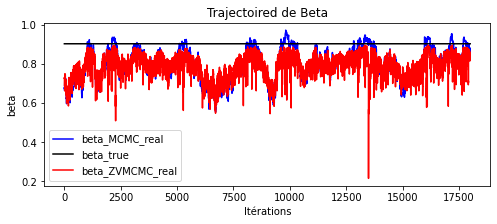

In [53]:


beta_true = [ 0.9022  for i in range (len(beta_MCMC_real))]
plt.figure(figsize=(8,3))
plt.plot(beta_MCMC_real, color="blue",label="beta_MCMC_real")
plt.plot(beta_true,color="black",label="beta_true")
plt.plot(beta_ZVMCMC_real,color= "red",label="beta_ZVMCMC_real")
plt.title("Trajectoired de Beta")
plt.xlabel("Itérations")
plt.ylabel("beta")
plt.legend()


mean_beta_MCMC_real = np.mean(beta_MCMC_real)
std_beta_MCMC_real= np.std(beta_MCMC_real)
lower_beta_MCMC_real = mean_beta_MCMC_real - 1.96* std_beta_MCMC_real/np.sqrt(len(beta_MCMC_real))
upper_beta_MCMC_real = mean_beta_MCMC_real + 1.96* std_beta_MCMC_real/np.sqrt(len(beta_MCMC_real))

mean_beta_ZVMCMC_real = np.mean(beta_ZVMCMC_real)
std_beta_ZVMCMC_real = np.std(beta_ZVMCMC_real)
lower_beta_ZVMCMC_real = mean_beta_ZVMCMC_real - 1.96* std_beta_ZVMCMC_real/np.sqrt(len(beta_ZVMCMC_real))
upper_beta_ZVMCMC_real = mean_beta_ZVMCMC_real + 1.96* std_beta_ZVMCMC_real/np.sqrt(len(beta_ZVMCMC_real))




print("Valeur de l'estimateur bayésien MCMC de beta : ", beta_bay_MCMC_real)
print("Valeur de l'estimateur bayésien ZVMCMC de beta : ", beta_bay_ZVMCMC_real)
print("la variance de l'estimateur MCMC de beta est de : ",np.var(beta_MCMC_real))
print("la variance de l'estimateur ZVMCMC de beta est de : ",np.var(beta_ZVMCMC_real))
print("Intervalle de confiance de confiance de beta real MCMC à 95% :",lower_beta_MCMC_real,upper_beta_MCMC_real)
print("Intervalle de confiance de confiance de beta real ZVMCMC à 95% :",lower_beta_ZVMCMC_real,upper_beta_ZVMCMC_real)




### Etape 4 : Construction de la méthode ZVMCMC avec variables de contrôles obtenu par régression Lasso

In [54]:
z_new = []
for i in range(len(z)):
    z1, z2, z3 = z[i,0], z[i,1], z[i,2]
    contrs = [z1,z2,z3, z1**2, z1*z2, z1*z3, z2**2, z2*z3, z3**2]
    z_new.append(contrs)
z_new = np.asarray(z_new)

In [36]:
# Regression Lasso
from sklearn.linear_model import Lasso

y = w
X = z_new
best_model = Lasso(alpha=0.1)
best_model.fit(X,y)
print(best_model.coef_)
coef = np.asarray(best_model.coef_)

/Users/aconrad/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3205610853145817, tolerance: 0.0003051823657059725
  model = cd_fast.enet_coordinate_descent(
/Users/aconrad/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.226837918488766, tolerance: 0.007325090313159817
  model = cd_fast.enet_coordinate_descent(


[[-1.37629715e-05  0.00000000e+00  0.00000000e+00 -1.57963103e-07
   1.56424804e-06  2.88191566e-07  1.04681518e-06 -7.40768119e-06
   6.34409952e-08]
 [ 2.60522542e-04 -1.38899931e-03  0.00000000e+00 -1.14739741e-06
   1.35430552e-05 -1.54607606e-06  2.63617855e-05 -1.03527661e-04
   3.83254721e-05]
 [ 1.04596837e-04  7.10342693e-04 -1.40654752e-03  2.97408421e-07
  -2.00777987e-05  1.53755730e-05 -2.04731741e-05  1.26631347e-04
  -7.93260583e-05]]


/Users/aconrad/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.42172782002608, tolerance: 0.01180135452563192
  model = cd_fast.enet_coordinate_descent(


In [37]:
def contr(coeff):
    cntr1, cntr2, cntr3 = [], [], []
    L = []
    for i in range(len(coeff)):
        l = []
        for j in range(len(coeff[0])):
            if coeff[i,j] != 0:
                l.append(j)
        L.append(l)
    for i in range(len(z_new)):
        cntr1.append([z_new[i,j] for j in L[0]])
        cntr2.append([z_new[i,j] for j in L[1]])
        cntr3.append([z_new[i,j] for j in L[2]])
    cntr1 = np.asarray(cntr1)
    cntr2 = np.asarray(cntr2)
    cntr3 = np.asarray(cntr3)
    return cntr1, cntr2, cntr3

In [38]:
def reg_lin(coeff,omega, alpha, beta):
    cntr1, cntr2, cntr3 = contr(coeff)
    print(cntr1)
    f1 = LinearRegression()
    f1.fit(cntr1,omega)
    c1 = f1.coef_
    f2 = LinearRegression()
    f2.fit(cntr2,alpha)
    c2 = f2.coef_
    f3 = LinearRegression()
    f3.fit(cntr3,beta)
    c3 = f3.coef_
    return(c1,c2,c3)

In [39]:
def insere0(l,i):
    if i == 0:
        L = [0]
        for j in range(len(l)):
            L.append(l[j])
        return(L)
    elif i > len(l):
        l.append(0)
        return(l)
    else:
        j = 0
        L = []
        while j < i:
            L.append(l[j])
            j += 1
        L.append(0)
        for k in range(j, len(l)):
            L.append(l[k])
        return(L)

In [40]:
def nv_c(coeff, c):
    for i in range(3):
        for j in range(9):
            if coeff[i,j] == 0:
                c[i] = insere0(c[i], j)
    return(c)

In [41]:
def a_B(coeff, omega, alpha, beta):
    c1, c2, c3 = reg_lin(coeff, omega, alpha, beta)
    c = [c1,c2,c3]
    c = nv_c(coeff,c)
    a1 = np.asarray([c[0][i] for i in range(3)])
    a2 = np.asarray([c[1][i] for i in range(3)])
    a3 = np.asarray([c[2][i] for i in range(3)])
    B = []
    for i in range(3):
        b11 = c[i][3]
        b12 = c[i][4]
        b13 = c[i][5]
        b22 = c[i][6]
        b23 = c[i][7]
        b33 = c[i][8]
        Bi = np.array([[b11, b12, b13], [b12, b22, b23], [b13, b23, b33]])
        B.append(Bi)
    return(a1,a2,a3, B[0], B[1], B[2])

In [42]:
def tr(B):
    return(B[0,0] + B[1,1] + B[2,2])

In [43]:
def wtilde(coeff, omega, alpha, beta):
    omega_ZVMCMC_lasso = []
    alpha_ZVMCMC_lasso = []
    beta_ZVMCMC_lasso = []
    a1,a2,a3, B1, B2, B3 = a_B(coeff, omega, alpha, beta)
    tr1,tr2,tr3 = tr(B1), tr(B2), tr(B3)
    for i in range(len(omega)):
        w = np.array([omega[i], alpha[i], beta[i]])
        b0 = np.dot(B1, w)
        b1 = np.dot(B2, w)
        b2 = np.dot(B3, w)
        trans0 =  - (0.5)*tr1 + np.dot(a1 + b0, z[i]) 
        trans1 =  - (0.5)*tr2 + np.dot(a2 + b1, z[i])
        trans2 =  - (0.5)*tr3 + np.dot(a3 + b2, z[i])
        om = omega[i] + trans0
        al = alpha[i] + trans1
        be = beta[i] + trans2
        omega_ZVMCMC_lasso.append(om)
        alpha_ZVMCMC_lasso.append(al)
        beta_ZVMCMC_lasso.append(be)
    omega_ZVMCMC_lasso = np.asarray(omega_ZVMCMC_lasso)
    alpha_ZVMCMC_lasso = np.asarray(alpha_ZVMCMC_lasso)
    beta_ZVMCMC_lasso = np.asarray(beta_ZVMCMC_lasso)
    return omega_ZVMCMC_lasso,alpha_ZVMCMC_lasso, beta_ZVMCMC_lasso

### Etape 5 : Application de la ZVMCMC lasso aux données simulées

In [44]:
omega_ZVMCMC_lasso,alpha_ZVMCMC_lasso, beta_ZVMCMC_lasso = wtilde(coef, omega_MCMC, alpha_MCMC,beta_MCMC)

[[ 6.12350848e+01  3.74973562e+03  7.62292410e+01 ...  1.54968184e+00
   2.24739646e+01  3.25924376e+02]
 [ 7.23913223e+01  5.24050355e+03 -2.87562403e+01 ...  1.57794255e-01
  -7.12539288e+00  3.21755843e+02]
 [ 7.23913223e+01  5.24050355e+03 -2.87562403e+01 ...  1.57794255e-01
  -7.12539288e+00  3.21755843e+02]
 ...
 [ 1.61758075e+01  2.61656748e+02 -1.39059565e+02 ...  7.39043146e+01
   1.99656304e+01  5.39381767e+00]
 [ 1.85758033e+01  3.45060467e+02 -1.86992547e+02 ...  1.01333581e+02
   3.38770369e+01  1.13255015e+01]
 [ 1.85758033e+01  3.45060467e+02 -1.86992547e+02 ...  1.01333581e+02
   3.38770369e+01  1.13255015e+01]]


In [45]:
omega_bay_ZVMCMC_lasso = np.mean(omega_ZVMCMC_lasso)
alpha_bay_ZVMCMC_lasso = np.mean(alpha_ZVMCMC_lasso)
beta_bay_ZVMCMC_lasso = np.mean(beta_ZVMCMC_lasso)

Valeur de l'estimateur bayésien ZVMCMC_lasso de omega :  0.12411010860575789
Erreur quadratique moyenne de l'estimateur omega ZVMCM_lasso : 0.0005812973369814402
la variance de l'estimateur ZVMCMC_lasso de omega est de :  0.0007307394667428038
Intervalle de confiance de confiance de omega ZVMCMC lassp à 95% : 0.12495829768407911 0.1252943548768038


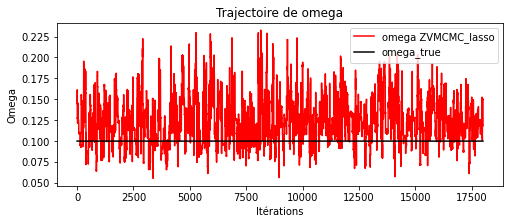

In [61]:
## Comparaison des estimateurs ZVMCMC et ZVMCMC_lasso pour omega 
omega_true = [omega for i in range (len(omega_ZVMCMC_lasso))]
plt.figure(figsize=(8,3))
plt.plot(omega_ZVMCMC_lasso,label="omega ZVMCMC_lasso",color= "red")
plt.plot(omega_true, label="omega_true",color="black")
plt.title("Trajectoire de omega")
plt.xlabel("Itérations")
plt.ylabel("Omega")
plt.legend()

mse_omega_ZVMCMC_lasso = np.mean((omega_bay_ZVMCMC_lasso - omega)**2)

mean_omega_ZVMCMC_lasso = np.mean(omega_ZVMCMC_lasso)
std_omega_ZVMCMC_lasso = np.std(omega_ZVMCMC_lasso)
lower_omega_ZVMCMC_lasso = mean_omega_ZVMCMC_lasso - 1.96* std_omega_ZVMCMC_lasso/np.sqrt(len(omega_ZVMCMC_lasso))
upper_beta_ZVMCMC_lasso = mean_omega_ZVMCMC_lasso + 1.96* std_omega_ZVMCMC_lasso/np.sqrt(len(omega_ZVMCMC_lasso))



print("Valeur de l'estimateur bayésien ZVMCMC_lasso de omega : ", omega_bay_ZVMCMC_lasso)

print("Erreur quadratique moyenne de l'estimateur omega ZVMCM_lasso :", mse_omega_ZVMCMC_lasso)
print("la variance de l'estimateur ZVMCMC_lasso de omega est de : ",np.var(omega_ZVMCMC_lasso))
print("Intervalle de confiance de confiance de omega ZVMCMC lassp à 95% :",lower_omega_ZVMCMC,upper_omega_ZVMCMC)


Valeur de l'estimateur bayésien ZVMCMC_lasso de omega :  0.21921992172569768
Erreur quadratique moyenne de l'estimateur alpha ZVMCM_lasso : 0.0003694053911419453
la variance de l'estimateur ZVMCMC_lasso de alpha est de :  0.0011462035627662329
Intervalle de confiance de confiance de alpha ZVMCMC lassp à 95% : 0.22025985706174975 0.22059395672520885


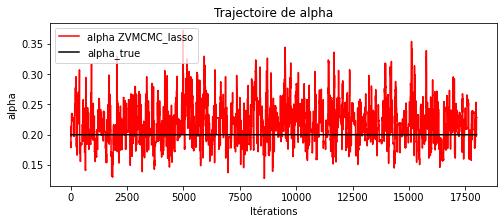

In [64]:
## Comparaison des estimateurs ZVMCMC et ZVMCMC_lasso 
alpha_true = [alpha for i in range (len(alpha_ZVMCMC_lasso))]
plt.figure(figsize=(8,3))
plt.plot(alpha_ZVMCMC_lasso,label="alpha ZVMCMC_lasso",color= "red")
plt.plot(alpha_true, label="alpha_true",color="black")
plt.title("Trajectoire de alpha")
plt.xlabel("Itérations")
plt.ylabel("alpha")
plt.legend()

mse_alpha_ZVMCMC_lasso = np.mean((alpha_bay_ZVMCMC_lasso - alpha)**2)

mean_alpha_ZVMCMC_lasso = np.mean(alpha_ZVMCMC_lasso)
std_alpha_ZVMCMC_lasso = np.std(alpha_ZVMCMC_lasso)
lower_alpha_ZVMCMC_lasso = mean_alpha_ZVMCMC_lasso - 1.96* std_alpha_ZVMCMC_lasso/np.sqrt(len(alpha_ZVMCMC_lasso))
upper_alpha_ZVMCMC_lasso = mean_alpha_ZVMCMC_lasso + 1.96* std_alpha_ZVMCMC_lasso/np.sqrt(len(alpha_ZVMCMC_lasso))



print("Valeur de l'estimateur bayésien ZVMCMC_lasso de omega : ", alpha_bay_ZVMCMC_lasso)

print("Erreur quadratique moyenne de l'estimateur alpha ZVMCM_lasso :", mse_alpha_ZVMCMC_lasso)
print("la variance de l'estimateur ZVMCMC_lasso de alpha est de : ",np.var(alpha_ZVMCMC_lasso))
print("Intervalle de confiance de confiance de alpha ZVMCMC lassp à 95% :",lower_alpha_ZVMCMC,upper_alpha_ZVMCMC)


Valeur de l'estimateur bayésien ZVMCMC_lasso de beta :  0.6498422616025078
Erreur quadratique moyenne de l'estimateur beta ZVMCM_lasso : 0.002515798721151259
la variance de l'estimateur ZVMCMC_lasso de beta est de :  0.0021617387194992873
Intervalle de confiance de confiance de beta ZVMCMC lasso à 95% : 0.6488058735382078 0.649305295093551


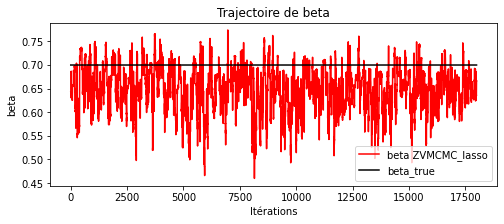

In [65]:
## Comparaison des estimateurs ZVMCMC et ZVMCMC_lasso 
beta_true = [beta for i in range (len(beta_ZVMCMC_lasso))]
plt.figure(figsize=(8,3))
plt.plot(beta_ZVMCMC_lasso,label="beta ZVMCMC_lasso",color= "red")
plt.plot(beta_true, label="beta_true",color="black")
plt.title("Trajectoire de beta")
plt.xlabel("Itérations")
plt.ylabel("beta")
plt.legend()

mse_beta_ZVMCMC_lasso = np.mean((beta_bay_ZVMCMC_lasso - beta)**2)

mean_beta_ZVMCMC_lasso = np.mean(beta_ZVMCMC_lasso)
std_beta_ZVMCMC_lasso = np.std(beta_ZVMCMC_lasso)
lower_beta_ZVMCMC_lasso = mean_beta_ZVMCMC_lasso - 1.96* std_beta_ZVMCMC_lasso/np.sqrt(len(beta_ZVMCMC_lasso))
upper_beta_ZVMCMC_lasso = mean_beta_ZVMCMC_lasso + 1.96* std_beta_ZVMCMC_lasso/np.sqrt(len(beta_ZVMCMC_lasso))



print("Valeur de l'estimateur bayésien ZVMCMC_lasso de beta : ", beta_bay_ZVMCMC_lasso)

print("Erreur quadratique moyenne de l'estimateur beta ZVMCM_lasso :", mse_beta_ZVMCMC_lasso)
print("la variance de l'estimateur ZVMCMC_lasso de beta est de : ",np.var(beta_ZVMCMC_lasso))
print("Intervalle de confiance de confiance de beta ZVMCMC lasso à 95% :",lower_beta_ZVMCMC,upper_beta_ZVMCMC)

## Question 4: 

### Etape 1 : Vérification de la présence d'auto-correlation 

In [326]:
from statsmodels.graphics.tsaplots import plot_acf

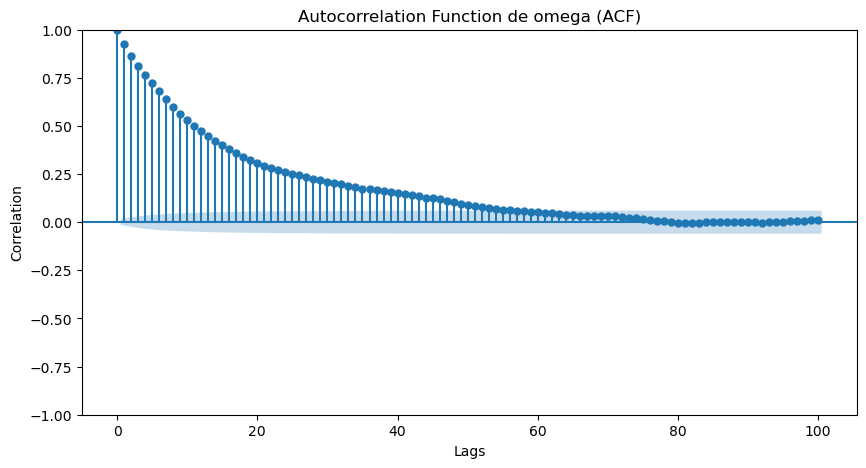

In [327]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(omega_ZVMCMC, lags=100, ax=ax)
ax.set(title='Autocorrelation Function de omega (ACF)', xlabel='Lags', ylabel='Correlation')
plt.show()

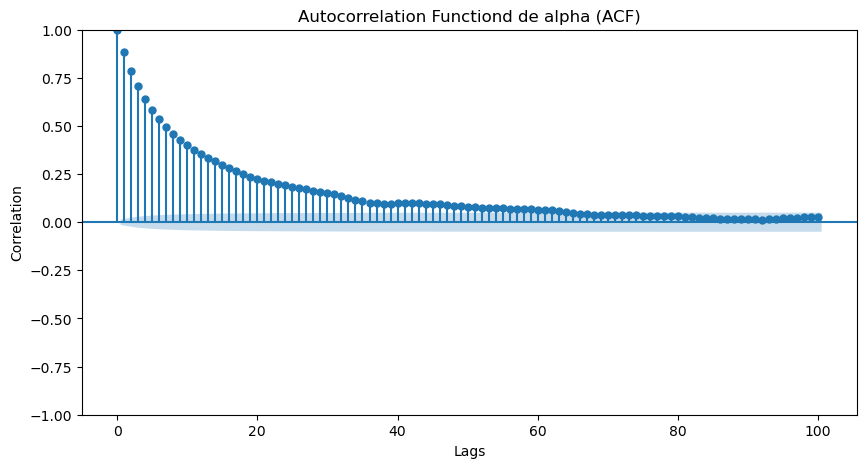

In [328]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(alpha_ZVMCMC, lags=100, ax=ax)
ax.set(title='Autocorrelation Functiond de alpha (ACF)', xlabel='Lags', ylabel='Correlation')
plt.show()

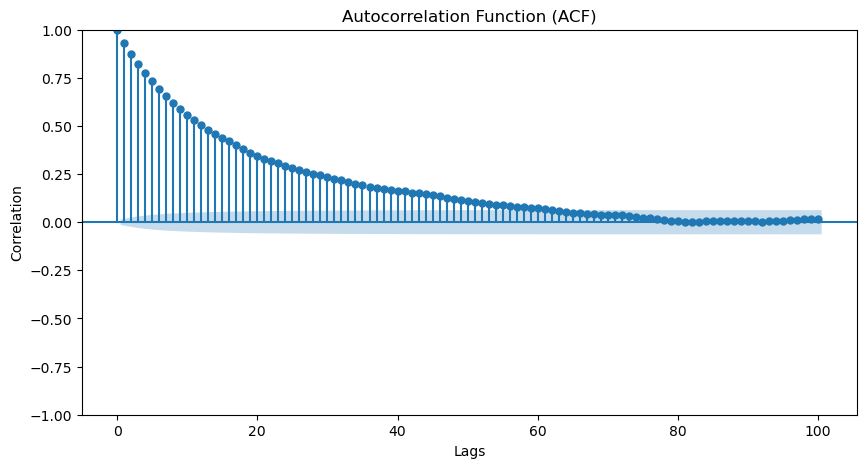

In [329]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(beta_ZVMCMC, lags=100, ax=ax)
ax.set(title='Autocorrelation Function (ACF)', xlabel='Lags', ylabel='Correlation')
plt.show()

### Étape 2 : Méthode de sous-échantillonnage 

In [330]:
from sklearn.utils import resample

# Définir le facteur de sous-échantillonnage
subsample_factor = 2

# Effectuer le sous-échantillonnage en utilisant la fonction resample de sklearn
subsampled_omega_MCMC = resample(omega_MCMC, replace=False, n_samples=len(omega_MCMC)//subsample_factor, random_state=42)
subsampled_alpha_MCMC = resample(alpha_MCMC, replace=False, n_samples=len(alpha_MCMC)//subsample_factor, random_state=42)
subsampled_beta_MCMC = resample(beta_MCMC, replace=False, n_samples=len(beta_MCMC)//subsample_factor, random_state=42)



In [331]:
## Calcul des estimateurs ZVMCMC
w = w_construct(subsampled_omega_MCMC,subsampled_omega_MCMC,subsampled_beta_MCMC)
z = z_construct(subsampled_omega_MCMC,subsampled_omega_MCMC,subsampled_beta_MCMC)
a = a_construct(w,z)

omega_ZVMCMC_subsampled,alpha_ZVMCMC_subsampled,beta_ZVMCMC_subsampled = ZVMCMC(subsampled_omega_MCMC,subsampled_omega_MCMC,subsampled_beta_MCMC)

In [332]:
## Estimateurs Bayésiens MCMC et ZVMCMC
omega_bay_ZVMCMC_subsampled = omega_ZVMCMC_subsampled.mean()
alpha_bay_ZVMCMC_subsampled = alpha_ZVMCMC_subsampled.mean()
beta_bay_ZVMCMC_subsampled = beta_ZVMCMC_subsampled.mean()
omega_bay_MCMC_subsampled = subsampled_omega_MCMC.mean()
alpha_bay_MCMC_subsampled = subsampled_alpha_MCMC.mean()
beta_bay_MCMC_subsampled = subsampled_beta_MCMC.mean()


Valeur de l'estimateur bayésien MCMC subsampled de omega :  0.15628586718166937
Valeur de l'estimateur bayésien ZVMCMC subsampled de omega :  0.29991375034050904
la variance de l'estimateur MCMC subsampled de omega est de :  0.0019208692010567832
la variance de l'estimateur ZVMCMC subsampled de omega est de :  0.00019162077817499833


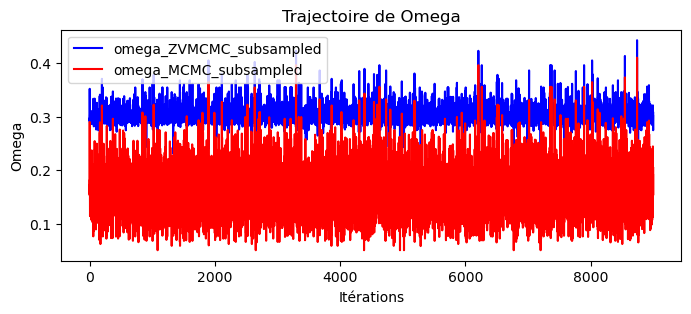

In [333]:
## Comparaison des estimateurs MCMC et ZVMCMC pour omega 

plt.figure(figsize=(8,3))
plt.plot(omega_ZVMCMC_subsampled, color="blue",label="omega_ZVMCMC_subsampled")
plt.plot(subsampled_omega_MCMC,color= "red",label="omega_MCMC_subsampled")
plt.title("Trajectoire de Omega")
plt.xlabel("Itérations")
plt.ylabel("Omega")
plt.legend()

print("Valeur de l'estimateur bayésien MCMC subsampled de omega : ", omega_bay_MCMC_subsampled )
print("Valeur de l'estimateur bayésien ZVMCMC subsampled de omega : ", omega_bay_ZVMCMC_subsampled)
print("la variance de l'estimateur MCMC subsampled de omega est de : ",np.var(subsampled_omega_MCMC))
print("la variance de l'estimateur ZVMCMC subsampled de omega est de : ",np.var(omega_ZVMCMC_subsampled))

Valeur de l'estimateur bayésien MCMC subsampled de alpha :  0.241130057657678
Valeur de l'estimateur bayésien ZVMCMC subsampled de alpha :  0.29991375034050904
la variance de l'estimateur MCMC subsampled de alpha est de :  0.0017753074756168845
la variance de l'estimateur ZVMCMC subsampled de alpha est de :  0.00019162077817499833


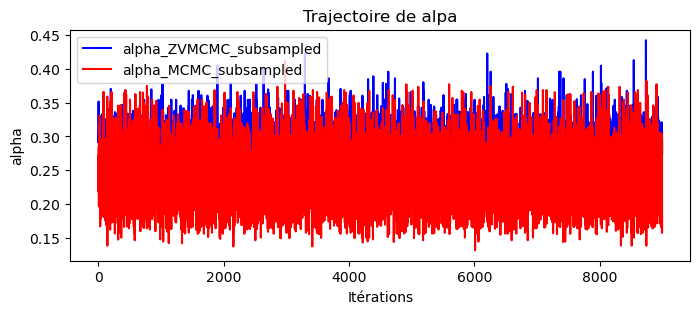

In [334]:
## Comparaison des estimateurs MCMC et ZVMCMC pour omega 

plt.figure(figsize=(8,3))
plt.plot(alpha_ZVMCMC_subsampled, color="blue",label="alpha_ZVMCMC_subsampled")
plt.plot(subsampled_alpha_MCMC,color= "red",label="alpha_MCMC_subsampled")
plt.title("Trajectoire de alpa")
plt.xlabel("Itérations")
plt.ylabel("alpha")
plt.legend()

print("Valeur de l'estimateur bayésien MCMC subsampled de alpha : ", alpha_bay_MCMC_subsampled )
print("Valeur de l'estimateur bayésien ZVMCMC subsampled de alpha : ", alpha_bay_ZVMCMC_subsampled)
print("la variance de l'estimateur MCMC subsampled de alpha est de : ",np.var(subsampled_alpha_MCMC))
print("la variance de l'estimateur ZVMCMC subsampled de alpha est de : ",np.var(alpha_ZVMCMC_subsampled))

Valeur de l'estimateur bayésien MCMC de beta :  0.6036289560050901
Valeur de l'estimateur bayésien ZVMCMC de beta :  0.24395184669888725
la variance de l'estimateur MCMC subsampled de beta est de :  0.00453418527229541
la variance de l'estimateur ZVMCMC subsampled de beta est de :  0.00029331513259528566


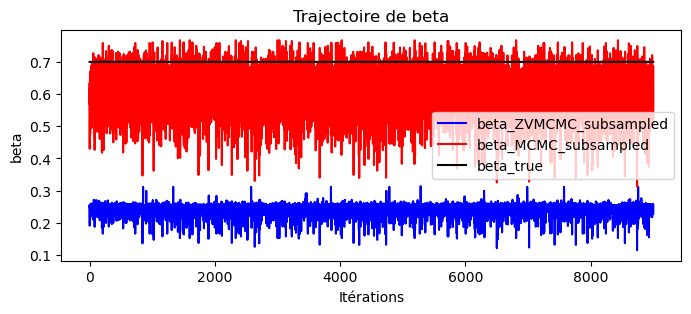

In [335]:
## Comparaison des estimateurs MCMC et ZVMCMC pour omega 
beta_true = [0.7 for i in range(len(beta_ZVMCMC_subsampled))]
plt.figure(figsize=(8,3))
plt.plot(beta_ZVMCMC_subsampled, color="blue",label="beta_ZVMCMC_subsampled")
plt.plot(subsampled_beta_MCMC,color= "red",label="beta_MCMC_subsampled")
plt.plot(beta_true,color="black",label= "beta_true")
plt.title("Trajectoire de beta")
plt.xlabel("Itérations")
plt.ylabel("beta")
plt.legend()

print("Valeur de l'estimateur bayésien MCMC de beta : ", beta_bay_MCMC_subsampled )
print("Valeur de l'estimateur bayésien ZVMCMC de beta : ", beta_bay_ZVMCMC_subsampled)
print("la variance de l'estimateur MCMC subsampled de beta est de : ",np.var(subsampled_beta_MCMC))
print("la variance de l'estimateur ZVMCMC subsampled de beta est de : ",np.var(beta_ZVMCMC_subsampled))